In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:

def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

def visualize_slices(image_path, label_path, prediction_path, slice_idx=None):
    image = load_nifti(image_path)
    label = load_nifti(label_path)
    prediction = load_nifti(prediction_path)

    if slice_idx is None:
        slice_idx = image.shape[-1] // 2

    if label.ndim == 4:
        label = np.argmax(label, axis=0)
    if prediction.ndim == 4:
        prediction = np.argmax(prediction, axis=0)

    def class_distribution(arr):
        counts = np.bincount(arr.flatten().astype(int), minlength=3)
        return tuple(int(c) for c in counts)

    print("Label class distribution:", class_distribution(label))
    print("Prediction class distribution:", class_distribution(prediction))

    # Define class colors
    class_colors = ["blue", "green", "red"]
    class_labels = ["Background", "GTVp", "GTVn"]
    cmap = ListedColormap(class_colors)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1]})

    # MRI image
    axes[0].imshow(image[:, :, slice_idx], cmap="gray")
    axes[0].set_title("MRI Scan")
    axes[0].axis("off")

    # Ground Truth
    axes[1].imshow(image[:, :, slice_idx], cmap="gray")
    axes[1].imshow(label[:, :, slice_idx], cmap=cmap, alpha=0.5, vmin=0, vmax=2)
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Prediction
    axes[2].imshow(image[:, :, slice_idx], cmap="gray")
    im_pred = axes[2].imshow(prediction[:, :, slice_idx], cmap=cmap, alpha=0.5, vmin=0, vmax=2)
    axes[2].set_title("Model Prediction")
    axes[2].axis("off")

    # Add colorbar in a separate axis
    cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(im_pred, cax=cbar_ax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(class_labels)
    cbar.set_label("Class Index")

    plt.subplots_adjust(wspace=0.05)
    plt.show()


Label class distribution: (1763729, 5743, 0)
Prediction class distribution: (1764785, 4181, 506)


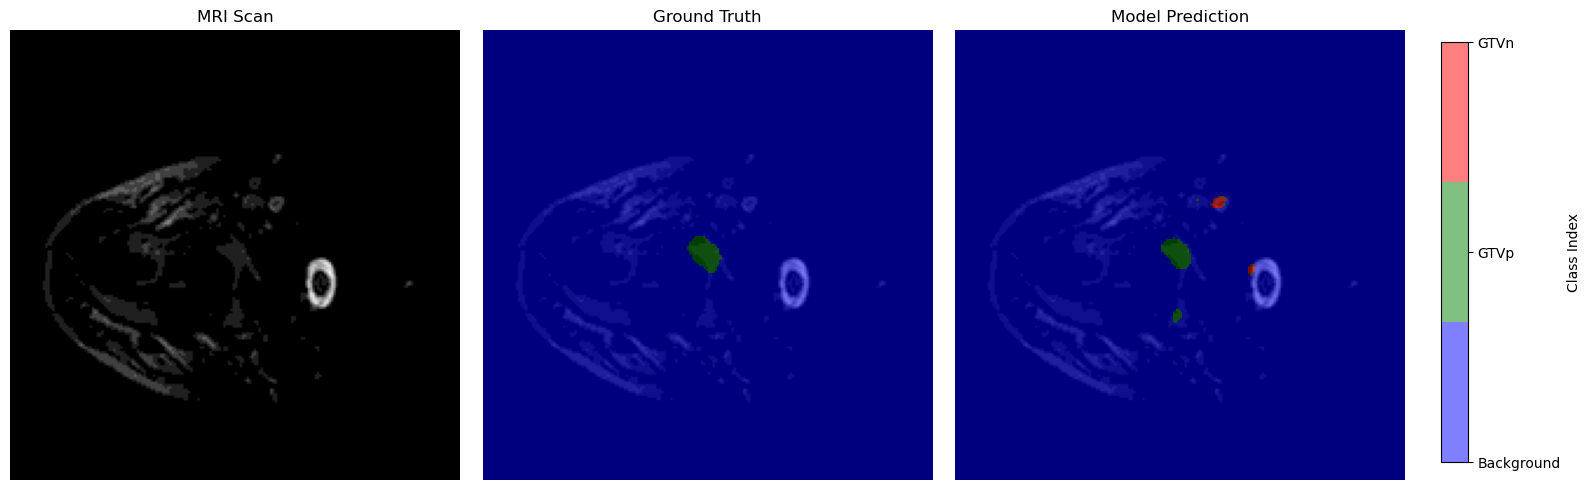

In [10]:
# Set file paths (adjust paths as needed)
image_path = "results/exp11_nnunet/predictions/image_1.nii.gz"
label_path = "results/exp11_nnunet/predictions/label_1.nii.gz"
prediction_path = "results/exp11_nnunet/predictions/prediction_1.nii.gz"

# Visualize a specific slice (e.g., slice 50)
visualize_slices(image_path, label_path, prediction_path, slice_idx=24)

In [4]:
def check_full_volume_label(label_path):
    """
    Load a NIfTI label file and print the distribution of voxel values.
    
    Args:
        label_path (str): Path to the label NIfTI file.
    
    Returns:
        dict: A dictionary with voxel values as keys and their counts as values.
    """
    # Load the label volume
    label_img = nib.load(label_path)
    label_data = label_img.get_fdata()

    # Compute the unique values and their counts
    unique_values, counts = np.unique(label_data, return_counts=True)
    distribution = dict(zip(unique_values, counts))
    
    print(f"Label distribution for {label_path}: {distribution}")
    
    # Check if tumor classes are present
    if 1 not in distribution and 2 not in distribution:
        print("Warning: No tumor classes (1 or 2) found in this label volume.")
    else:
        print("Tumor classes found in this label volume.")
    
    return distribution




In [5]:

def print_image_info(image_path):
    img = nib.load(image_path)
    shape = img.shape  # Voxel dimensions (e.g., (H, W, D))
    voxel_sizes = img.header.get_zooms()  # Physical size per voxel (e.g., in mm)
    print(f"Image shape (voxels): {shape}")
    print(f"Voxel dimensions (mm): {voxel_sizes}")



In [6]:
label_file = "/cluster/projects/vc/data/mic/open/HNTS-MRG/train/194/preRT/194_preRT_mask.nii.gz"
check_full_volume_label(label_file)
print_image_info(label_file)


Label distribution for /cluster/projects/vc/data/mic/open/HNTS-MRG/train/194/preRT/194_preRT_mask.nii.gz: {0.0: 21204213, 1.0: 25240, 2.0: 4211}
Tumor classes found in this label volume.
Image shape (voxels): (512, 512, 81)
Voxel dimensions (mm): (0.5, 0.5, 2.0)


In [ ]:
import json
import matplotlib.pyplot as plt

with open("results/history.json", "r") as f:
    history = json.load(f)

train_loss = history["train"]["loss"]
val_loss = history["val"]["loss"]
train_dice = history["train"]["dice"]
val_dice = history["val"]["dice"]

epochs = list(map(int, train_loss.keys()))

plt.figure()
plt.plot(epochs, [train_loss[str(e)] for e in epochs], label="Train Loss")
plt.plot(epochs, [val_loss[str(e)] for e in epochs], label="Val Loss")
plt.plot(epochs, [train_dice[str(e)] for e in epochs], label="Train Dice")
plt.plot(epochs, [val_dice[str(e)] for e in epochs], label="Val Dice")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.title("Training / Validation Curves")
plt.grid()
plt.show()
